### Name Entitiy Recognition project using RNN

NER is an information extraction technique to identify and classify "entities" (words) in a text. These entities can be of different natures: names of places, organizations, a schedule. The NER has a wide variety of use cases in a company. Messaging systems like Gmail can use it to send you a calendar notification if a time is mentioned in the email, or to remind you to attach a file in case you send the email without an attachment. It is also interesting to use this type of model to extract important information from a text more easily.
More info about dataset:
-   The column "Sentence #" represents the identifier of the sentence.
-   The Word column represents one of the words in the sentence.
-   The POS column gives the grammatical nature of our word.
-   The Tag column corresponds to the entity that we will try to predict.

In [1]:
import pandas as pd
import numpy as np


In [25]:
data= pd.read_csv('ner_dataset.csv', encoding ='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
len(data['Sentence #'].unique()) -1

47959

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [35]:
#let's try to create vocabs before we changed the data set 
w_vocab= list(set(data['Word'].to_list()))
t_vocab = list(set(data['Tag'].to_list()))
print(len(w_vocab), len(t_vocab))
print(len(w_vocab)==len(word_vocab))

35178 17
True


In [38]:
#both are same 
print(w_vocab[:10], '\n', word_vocab[:10])
print('\n')
print(tag_vocab, '\n', t_vocab)

['Leading', 'edged', '320', 'quarter-on-quarter', 'Liban', 'Rony', 'unexplored', 'PSV', 'frontier', 'Mulino'] 
 ['Leading', 'edged', '320', 'quarter-on-quarter', 'Liban', 'Rony', 'unexplored', 'PSV', 'frontier', 'Mulino']


['B-nat', 'B-art', 'B-eve', 'B-gpe', 'I-eve', 'O', 'I-per', 'I-org', 'I-tim', 'B-per', 'I-nat', 'I-geo', 'I-gpe', 'B-geo', 'B-tim', 'B-org', 'I-art'] 
 ['B-nat', 'B-art', 'B-eve', 'B-gpe', 'I-eve', 'O', 'I-org', 'I-per', 'I-tim', 'B-per', 'I-nat', 'B-tim', 'I-gpe', 'B-geo', 'B-org', 'I-geo', 'I-art']


In [5]:
df = data.fillna(method='ffill', axis =0)
df = df.groupby('Sentence #').agg(list).reset_index()
df.tail()

,Sentence #,Word,POS,Tag
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
47958,Sentence: 9999,"[The, United, Nations, is, praising, the, use,...","[DT, NNP, NNP, VBZ, VBG, DT, NN, IN, JJ, NNS, ...","[O, B-org, I-org, O, O, O, O, O, O, O, O, O, O..."


 The objective here is to predict the list of Tag according to the words of the sentence.

In [7]:
# let us visualise distribution of number of words
import matplotlib.pyplot as plt
df['word_count'] = df['Word'].apply(lambda x: len(x))


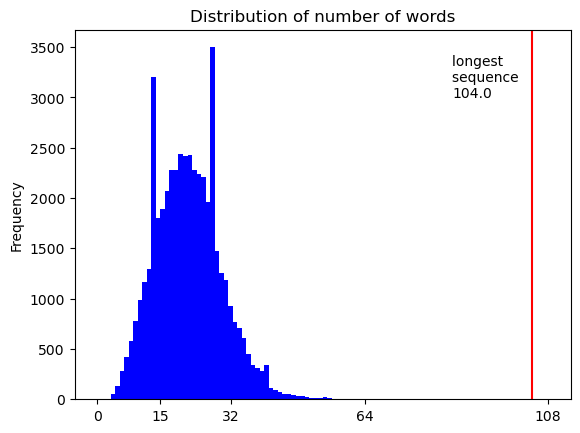

In [24]:
#we can represent word count as follows and then also mark longest sequence in the corpus
summary = df['word_count'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
df['word_count'].plot.hist(xticks=[0,15, 32,64,108], bins=100, range=[0,108],color='blue').axvline(x=summary['100%'],c='red')
plt.title('Distribution of number of words')
plt.text(85, 3000, 'longest \nsequence \n'+str(summary['100%']))
plt.show()


To continue, we will create a vocabolary, and vocabolary of tags , then dictionary with tokens and their indexes, and vice versa indexes as keys and tokens as values.   

In [32]:
word_vocab = list(set(word for entry in df['Word'].to_list() for word in entry))
tag_vocab = list(set(tag for entry in df['Tag'].to_list() for tag in entry))

In [33]:
print(len(word_vocab))
print(len(tag_vocab))

35178
17


In [39]:
word2idx = {w:i for i,w in enumerate(word_vocab)}
tag2idx = {t:i for i, t in enumerate(tag_vocab)}
idx2word = {i:w for i, w in enumerate(word_vocab)}
idx2tag = {i:t for i, t in enumerate(tag_vocab)}


We created vocabularies and idx to word and tag mappings, this is also possible with keras.preprocessing module.  Tokenizer Class enables to transform each text into sequence of intergers where each integer is index of the token in dictionary.

In [40]:
df['word_str'] = df['Word'].apply(lambda x: ' '.join(x))
df['tag_str'] = df['Tag'].apply(lambda x:' '.join(x))



In [41]:
import tensorflow as tf
word_token = tf.keras.preprocessing.text.Tokenizer(num_words=10000, lower=True)
#for tag tokenizer, we do not want to font size to be lower, also we do not want any filter to be applied , like punctuation, or line breaks
tag_token = tf.keras.preprocessing.text.Tokenizer(num_words=10000, split=' ', lower=False, filters=' ')

word_token.fit_on_texts(df['word_str'])
tag_token.fit_on_texts(df['tag_str'])


In [44]:
#we can then generate vocabulary and token integer mappings 
w2idx = word_token.word_index
idx2w = word_token.index_word
t2idx = tag_token.word_index
idx2t = tag_token.index_word

w_counts = word_token.word_counts
t_counts = tag_token.word_counts



In [99]:
print(len(w2idx), len(word2idx)) # word2idx is longer I guess because of stop words, and because lower and upper case 
print(len(t2idx), len(tag2idx))


27953 35178
18 17


In [100]:
print(list(w2idx.items())[:20], '\n', list(word2idx.items())[:20]) 

[('the', 1), ('in', 2), ('of', 3), ('to', 4), ('a', 5), ('and', 6), ("'s", 7), ('for', 8), ('has', 9), ('on', 10), ('is', 11), ('that', 12), ('have', 13), ('u', 14), ('with', 15), ('said', 16), ('was', 17), ('at', 18), ('says', 19), ('s', 20)] 
 [('Leading', 0), ('edged', 1), ('320', 2), ('quarter-on-quarter', 3), ('Liban', 4), ('Rony', 5), ('unexplored', 6), ('PSV', 7), ('frontier', 8), ('Mulino', 9), ('Poiree', 10), ('banning', 11), ('Navarre', 12), ('sailors', 13), ('sprang', 14), ('Tirah', 15), ('randomly', 16), ('institutional', 17), ('994', 18), ('furor', 19)]


it seems different but this should not make any difference 

In [101]:
t2idx       # in tensorflow indexing starts from 1 not from 0

{'O': 1,
 'B-geo': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-per': 5,
 'B-per': 6,
 'I-org': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'I-tim': 10,
 'B-art': 11,
 'B-eve': 12,
 'I-art': 13,
 'I-eve': 14,
 'B-nat': 15,
 'I-gpe': 16,
 'I-nat': 17,
 '.': 0}

In [102]:
t2idx['.'] = 0
idx2t[0]='.'

In [52]:
max_sequence =max(len(s) for s in df['Word'].to_list())
max_sequence

104

Transforming entries into sequence of integers

In [103]:
X_raw= word_token.texts_to_sequences(df['word_str'])
Y_raw= tag_token.texts_to_sequences(df['tag_str'])

In [104]:
print(X_raw[:1])
print(Y_raw[:4])


[[260, 3, 997, 13, 1838, 245, 452, 4, 545, 1, 121, 2, 60, 6, 595, 1, 861, 3, 184, 89, 21, 12, 54]]
[[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1], [8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1], [1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 9, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


Next step is dividing the text into sequences, which results in numpy array with dimmensions of number of samples and number of timestemps. Good indicator of number of timestemps is maximum length of sequence. Anything shorter will be filled with 0 and longer sequences are trunctuated to match desired lenght.  This makes sure that all sequences have the same length.
value is padding value, either string or integer 

In [105]:
from sklearn.model_selection import train_test_split
X = tf.keras.preprocessing.sequence.pad_sequences(X_raw, maxlen= max_sequence, padding='post')
Y = tf.keras.preprocessing.sequence.pad_sequences(Y_raw, padding='post')

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=234354353)

In [140]:
len(w2idx.keys())

27953

To build classification model we will use 2 layers of bidirectional LSTM layers. Main strength of RNN is possibility to use previous information for current prediction task. There is some input on which parameters are applied, and with output ht which is then used as input for next network layer. It has chain structure where information is passed from one part of network to another. LSTM are special RNNs in cases where for next word to be predicted it needs more context (distance between the information available and task is large). They also have chain strucutre but there is not one layer per network but 4 and they communicating with each other:

- There is Ct vector which acts like memory vector, goes through the LSTM cell like conveyor belt. 
- Then there are 3 gates which regulate how much inforamtion will be added to cell state( Ct). they are composed of sigmoid layer which outputs numbers between 0 and 1 describing how much information should go through:
  
    - first layer decides which components to forget and which to pass through
    - Input vector which stores the retained components to Ct
    - output vector which decides what to produce as output. Basis for that is Ct which goes through sigmoid layer, and this output gets transformed via tanh layer(produce values between -1 and 1).

What bidirectional means? We roughly explained how one-directional network works since it resembles with the way we speak, read and listen. Howere sometimes we have random accesss to input sequences and having bi-directional lstm calculations might be beneficial.  In this case, there are two Ct vectors (hidden state vectors), one for each direction. 

TimeDistributed layer : we intend to output to use same dense layer to each of the outputs of LSTM at each step 

In [108]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import  InputLayer, SpatialDropout1D, Embedding, LSTM, Dense, GRUCell, RNN, TimeDistributed, Dropout, Bidirectional, GlobalAveragePooling1D

model = Sequential()
#64 is length of the vector for each word
model.add(Embedding(len(w2idx.keys()), output_dim=max_sequence, input_length=max_sequence))

model.add(Bidirectional(LSTM(max_sequence, return_sequences=True, activation='tanh')))
model.add(Bidirectional(LSTM(max_sequence, return_sequences=True, activation='tanh')))

model.add(TimeDistributed(Dense(len(t2idx)+1, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 104, 104)          2907112   
                                                                 
 bidirectional_16 (Bidirecti  (None, 104, 208)         173888    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 104, 208)         260416    
 onal)                                                           
                                                                 
 time_distributed_8 (TimeDis  (None, 104, 19)          3971      
 tributed)                                                       
                                                                 
Total params: 3,345,387
Trainable params: 3,345,387
Non-trainable params: 0
____________________________________________

In [189]:
history = model.fit(x_train, y_train, epochs= 3, batch_size= 16, validation_data=[x_test, y_test])

Epoch 1/3


2398/2398 [==============================] - 2358s 983ms/step - loss: 0.1012 - acc: 0.9670 - val_loss: 0.0993 - val_acc: 0.9682
Epoch 2/3
2398/2398 [==============================] - 1395s 582ms/step - loss: 0.0865 - acc: 0.9708 - val_loss: 0.0933 - val_acc: 0.9697
Epoch 3/3
2398/2398 [==============================] - 2171s 906ms/step - loss: 0.0774 - acc: 0.9734 - val_loss: 0.0912 - val_acc: 0.9703


In [190]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=128)
print('test loss:', test_loss, 'test_acc:', test_accuracy)

75/75 [==============================] - 96s 1s/step - loss: 0.0912 - acc: 0.9703
test loss: 0.09124068915843964 test_acc: 0.9703238010406494


In [191]:
i = np.random.randint(1, x_test.shape[0])
word_list = list(w2idx.keys())
print("This is sentence number:",i)
p = model.predict(np.array([x_test[i]]))
#print(p)
pp = np.argmax(p, axis=-1)


This is sentence number: 8452
1/1 [==============================] - 0s 185ms/step


In [192]:
print(pp[0])

[8 1 1 1 1 1 1 1 1 1 1 1 1 4 7 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [193]:

tag_list = list(t2idx.keys())
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], pp[0]):
    print("{:15}{}\t{}".format(word_list[w-1], tag_list[true-1], tag_list[pred-1]))

Word           True 	 Pred

------------------------------
pakistani      B-gpe	B-gpe
officials      O	O
say            O	O
unknown        O	O
gunmen         O	O
have           O	O
opened         O	O
fire           O	O
on             O	O
a              O	O
bus            O	O
carrying       O	O
the            O	O
sri            B-org	B-org
lankan         I-org	I-org
cricket        O	O
team           O	O
killing        O	O
at             O	O
least          O	O
five           O	O
police         O	O
officers       O	O
and            O	O
wounding       O	O
six            O	O
sri            O	O
lankan         B-org	I-org
players        I-org	O
marginalize    O	O
marginalize    O	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize    .	.
marginalize 